In [28]:
using Pkg
Pkg.activate(".")

Pkg.add("Plots")
Pkg.add("Random")

using Plots
using Random

default(aspect_ratio=:equal,
	cbar = false,
	showaxis = false,
	c = palette(:grays,rev=true),
	size = (512,512),
	yflip=true
)

  Activating project at `c:\School\BS Thesis\src`


   Resolving package versions...

  No Changes to `C:\School\BS Thesis\src\Project.toml`
  No Changes to `C:\School\BS Thesis\src\Manifest.toml`

   Resolving package versions...

  No Changes to `C:\School\BS Thesis\src\Project.toml`
  No Changes to `C:\School\BS Thesis\src\Manifest.toml`


In [23]:
function initiate_grid(type::String, L::Int=8)
    # May add line to ensure that L is even.
    if L%2 == 1
        L=L+1
    end

    grid = zeros(Int,L,L)

    if type == "center"
        grid[L÷2:L÷2+1,L÷2:L÷2+1] .= 1
    elseif type == "outer_corner"
        grid[1,1] = 1
        grid[1,end] = 1
        grid[end,1] = 1
        grid[end,end] = 1 
    elseif type == "inner_corner"
        grid[L÷4,L÷4] = 1
        grid[L÷4,end-L÷4+1] = 1
        grid[end-L÷4+1,L÷4] = 1
        grid[end-L÷4+1,end-L÷4+1] = 1
    else
        error("ERROR: Not a valid initital seating arrangement type")
    end

    return grid
end

initiate_grid (generic function with 2 methods)

In [26]:
function initiate_grid_rand(num_learned::Int=4,L::Int=8)
    grid = zeros(Int,L,L)

    while sum(grid) < num_learned
        grid[rand(1:L),rand(1:L)] = 1
    end

    return grid
end

initiate_grid_rand (generic function with 3 methods)

In [27]:
test_grid = initiate_grid_rand(4,10)

10×10 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0

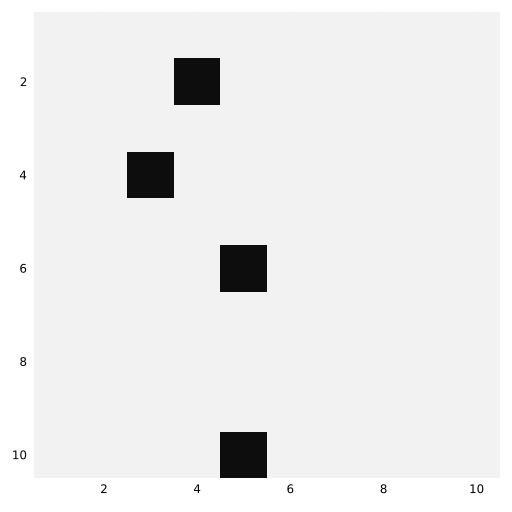

In [19]:
heatmap(test_grid)